In [343]:
import pandas as pd
import seaborn as sns
import numpy as np
import geocoder
import gmaps
import statsmodels.api as sm

import pytz

import psycopg2

from sklearn.linear_model import Ridge

import spacy

import swifter

import matplotlib.patches as mpatches

import requests


In [344]:
# Plot settings
%pylab inline

figsize(15, 9)

import matplotlib.style as style

style.use('childsafeai')

Populating the interactive namespace from numpy and matplotlib


In [345]:
from local_settings import GOOGLE_API_KEY

gmaps.configure(GOOGLE_API_KEY)

# Tests

## Processing

In [346]:
tests = requests.get("https://covidtracking.com/api/states/daily").json()
tests_df = pd.DataFrame(tests)
tests_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200411,AK,257.0,7475.0,NaN,NaN,31.0,NaN,NaN,NaN,...,31.0,7732.0,7732.0,7732.0,02,1.0,3.0,289.0,11.0,300.0
1,20200411,AL,3191.0,18058.0,NaN,NaN,402.0,NaN,NaN,NaN,...,402.0,21249.0,21249.0,21249.0,01,11.0,34.0,0.0,223.0,223.0
2,20200411,AR,1226.0,17352.0,NaN,86.0,130.0,NaN,43.0,33.0,...,130.0,18578.0,18578.0,18578.0,05,1.0,0.0,1403.0,55.0,1458.0
3,20200411,AS,0.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,3.0,3.0,60,0.0,0.0,0.0,0.0,0.0
4,20200411,AZ,3393.0,37137.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,40530.0,40530.0,40530.0,04,11.0,0.0,2515.0,281.0,2796.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051,20200302,WA,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,34.0,34.0,34.0,53,3.0,0.0,0.0,4.0,4.0
2052,20200301,RI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,44,NaN,NaN,NaN,NaN,NaN
2053,20200301,WA,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30.0,30.0,30.0,53,3.0,0.0,0.0,12.0,12.0
2054,20200229,WA,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.0,18.0,18.0,53,1.0,0.0,0.0,9.0,9.0


In [347]:
tests_df['dateChecked'] = pd.to_datetime(tests_df['dateChecked'])
tests_df['Date'] = pd.to_datetime(tests_df['dateChecked'].dt.date)

In [348]:
tests_df[['positive', 'negative', 'pending', 'death', 'total']] = tests_df[['positive', 'negative', 'pending', 'death', 'total']].astype(int, errors='ignore')

In [349]:
tests_df['completed'] = tests_df['positive'] + tests_df['negative']

In [350]:
us_state_abbreviations = pd.read_csv('data/us_state_abbreviations.csv')
us_state_abbreviations = us_state_abbreviations.groupby('Abbreviation')['Full Name'].max().to_dict()
us_state_abbreviations[np.nan] = 'Unknown'
us_state_abbreviations['DC'] = 'District of Columbia'
us_state_abbreviations['AS'] = 'American Samoa'
us_state_abbreviations['GU'] = 'Guam'
us_state_abbreviations['MP'] = 'Marianas'
us_state_abbreviations['PR'] = 'Marianas'
us_state_abbreviations['VI'] = 'Virgin Island'

tests_df['State'] = tests_df['state'].map(lambda x: us_state_abbreviations[x] if not x == np.nan else x)
tests_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,Date,completed,State
0,20200411,AK,257.0,7475.0,NaN,NaN,31.0,NaN,NaN,NaN,...,7732.0,02,1.0,3.0,289.0,11.0,300.0,2020-04-11,7732.0,Alaska
1,20200411,AL,3191.0,18058.0,NaN,NaN,402.0,NaN,NaN,NaN,...,21249.0,01,11.0,34.0,0.0,223.0,223.0,2020-04-11,21249.0,Alabama
2,20200411,AR,1226.0,17352.0,NaN,86.0,130.0,NaN,43.0,33.0,...,18578.0,05,1.0,0.0,1403.0,55.0,1458.0,2020-04-11,18578.0,Arkansas
3,20200411,AS,0.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,...,3.0,60,0.0,0.0,0.0,0.0,0.0,2020-04-11,3.0,American Samoa
4,20200411,AZ,3393.0,37137.0,NaN,NaN,NaN,NaN,NaN,NaN,...,40530.0,04,11.0,0.0,2515.0,281.0,2796.0,2020-04-11,40530.0,Arizona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051,20200302,WA,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.0,53,3.0,0.0,0.0,4.0,4.0,2020-03-02,NaN,Washington
2052,20200301,RI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,44,NaN,NaN,NaN,NaN,NaN,2020-03-01,NaN,Rhode Island
2053,20200301,WA,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,53,3.0,0.0,0.0,12.0,12.0,2020-03-01,NaN,Washington
2054,20200229,WA,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.0,53,1.0,0.0,0.0,9.0,9.0,2020-02-29,NaN,Washington


In [351]:
state_populations = pd.read_excel('data/us_state_populations.xlsx')
tests_df['State Population'] = tests_df['State'].map(lambda x: state_populations[state_populations['State'] == x]['2020 Pop.\xa0'].sum())
tests_df['Tests per Capita'] = (tests_df['total'] / tests_df['State Population'])

In [352]:
%store tests_df

Stored 'tests_df' (DataFrame)


## Analysis

In [353]:
tests_df.groupby('Date')['completed'].sum().max()

2665666.0

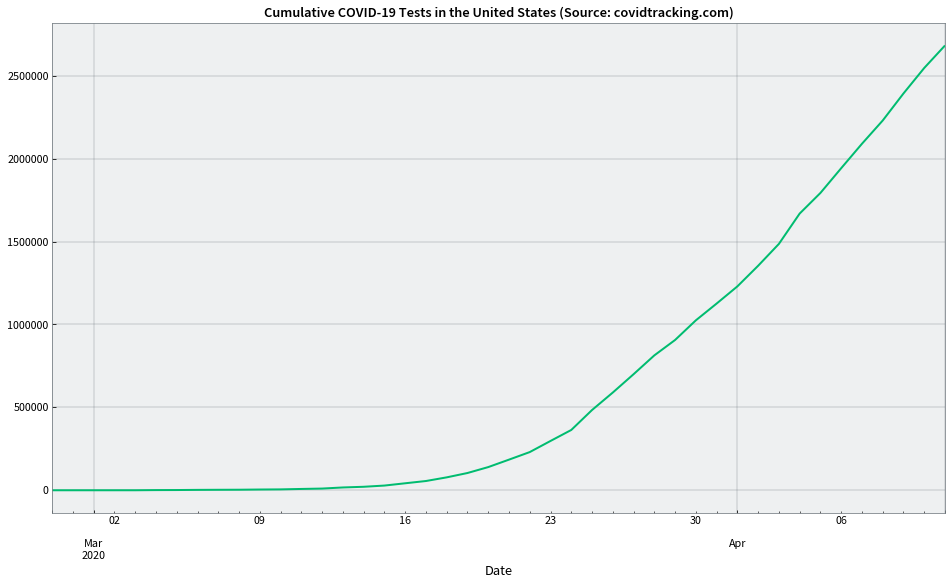

In [354]:
tests_df.groupby('Date')['total'].sum().plot(kind='line', 
                                                    title="Cumulative COVID-19 Tests in the United States (Source: covidtracking.com)")

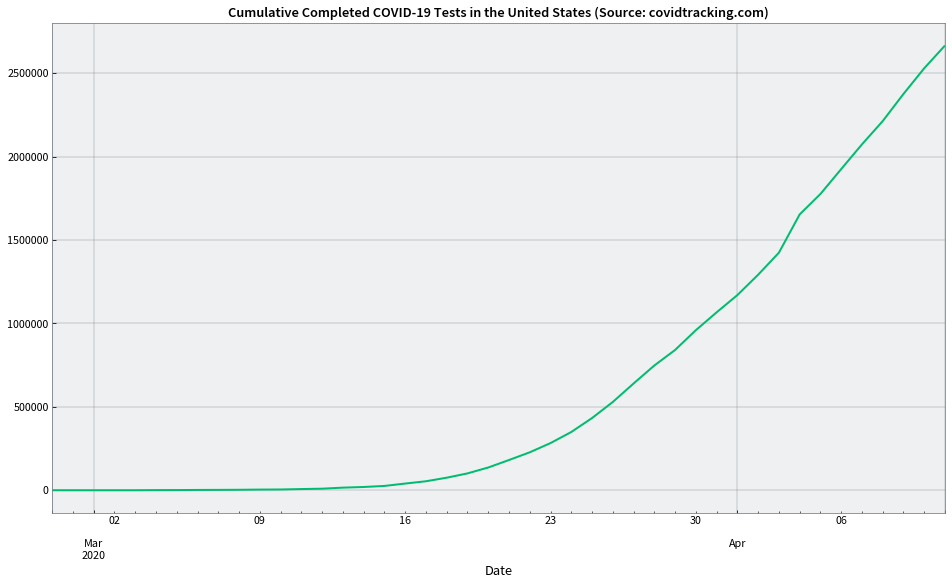

In [355]:
tests_df.groupby('Date')['completed'].sum().plot(kind='line', 
                                                    title="Cumulative Completed COVID-19 Tests in the United States (Source: covidtracking.com)")

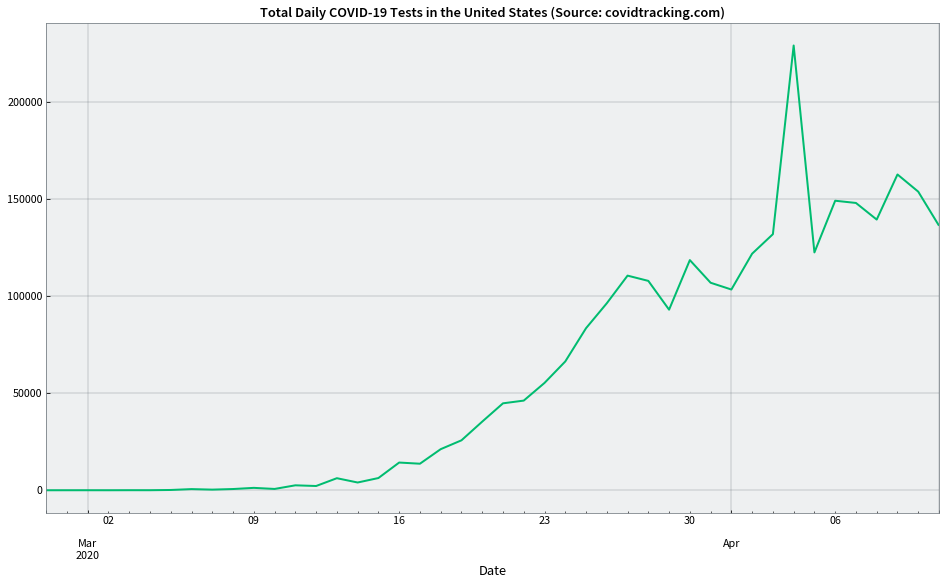

In [356]:
tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line', 
                                                    title="Total Daily COVID-19 Tests in the United States (Source: covidtracking.com)")

In [306]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

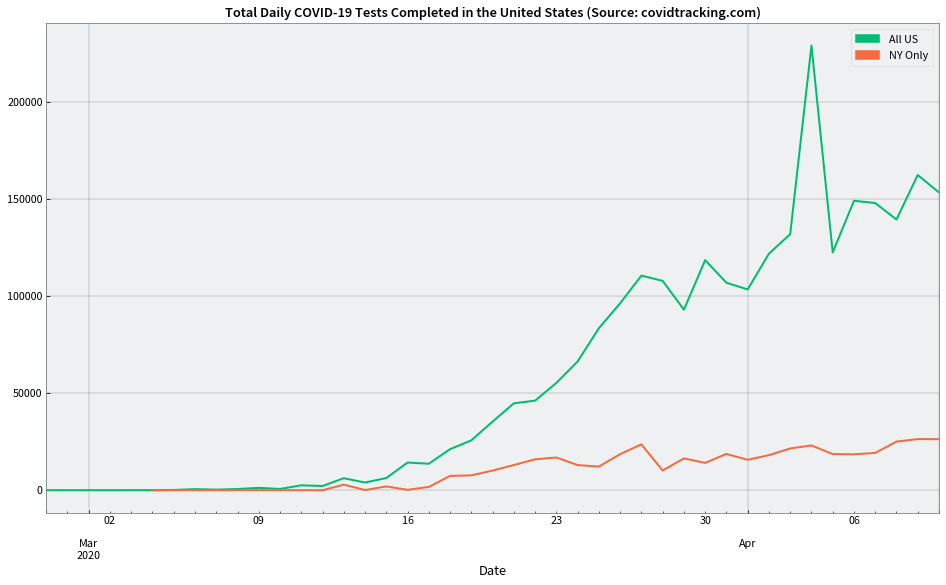

In [307]:
figsize(16, 9)
ax = tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line', label="US",
                                                    title="Total Daily COVID-19 Tests Completed in the United States (Source: covidtracking.com)")

tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line', ax=ax)

ax.legend(handles=[mpatches.Patch(color="#00bc70", label="All US"),
                   mpatches.Patch(color="#f36c3f", label="NY Only")])

In [308]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('Date')['total'].sum().diff().mean()

124935.72222222222

In [309]:
tests_df[(tests_df['state'] == 'NY') & (tests_df['Date'] >= '2020-03-23')].groupby('Date')['total'].sum().diff().mean()

18866.444444444445

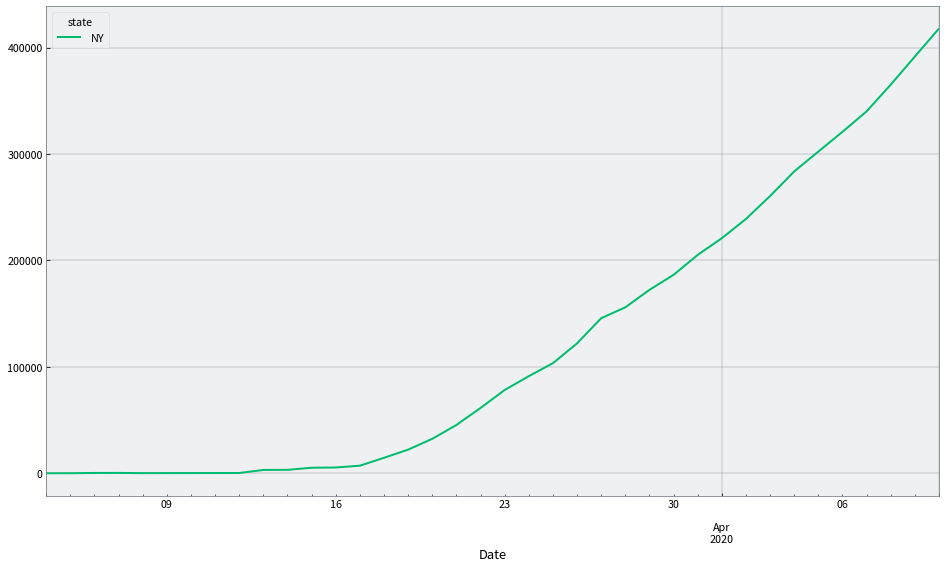

In [310]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line')

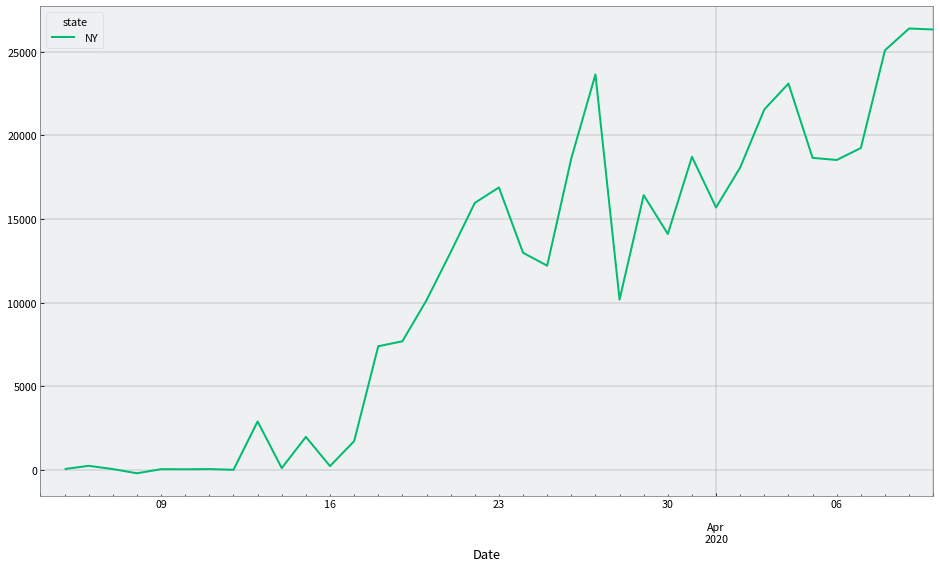

In [311]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line')

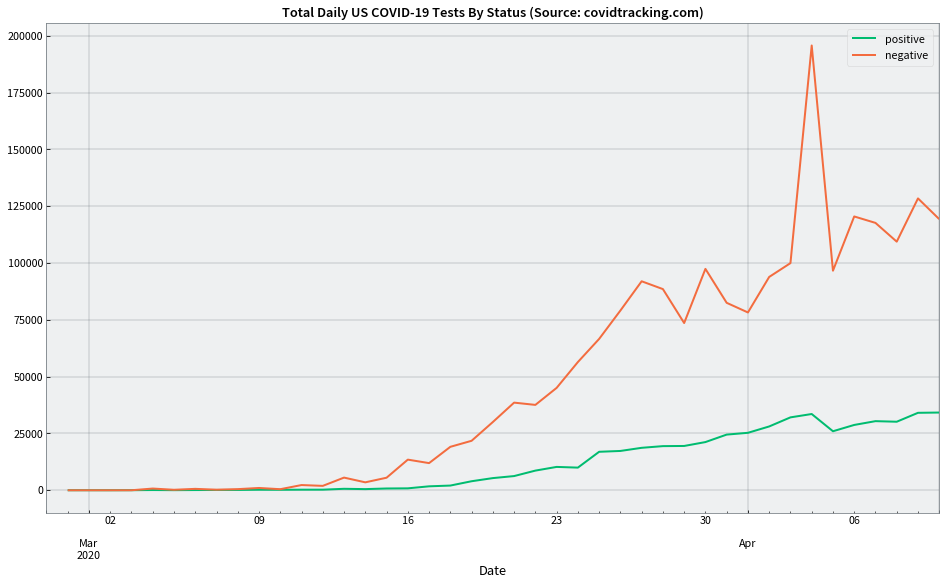

In [312]:
tests_df.groupby('Date')[['positive', 'negative']].sum().diff().plot(kind='line', 
                                                                     title="Total Daily US COVID-19 Tests By Status (Source: covidtracking.com)")

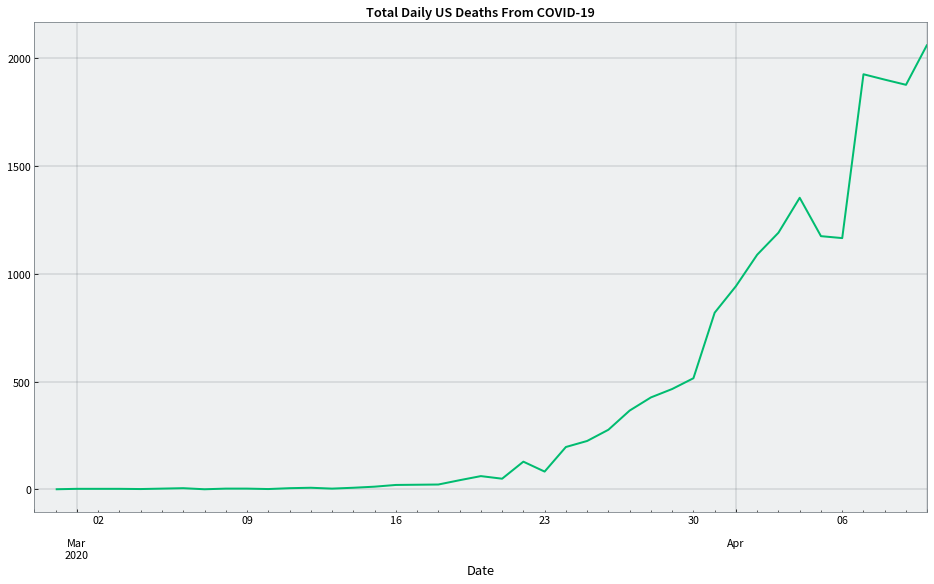

In [313]:
tests_df.groupby('Date')['death'].sum().diff().plot(kind='line',
                                                    title="Total Daily US Deaths From COVID-19")

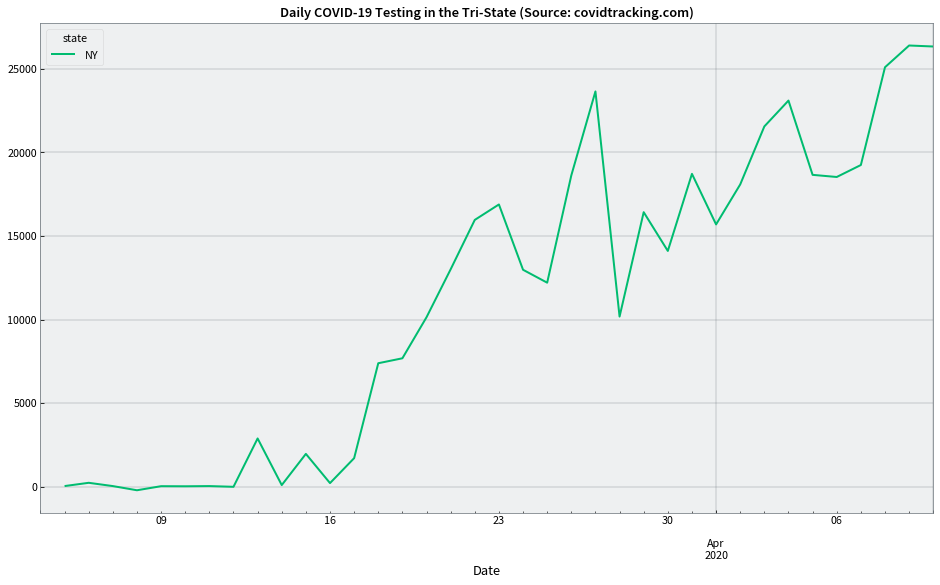

In [314]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

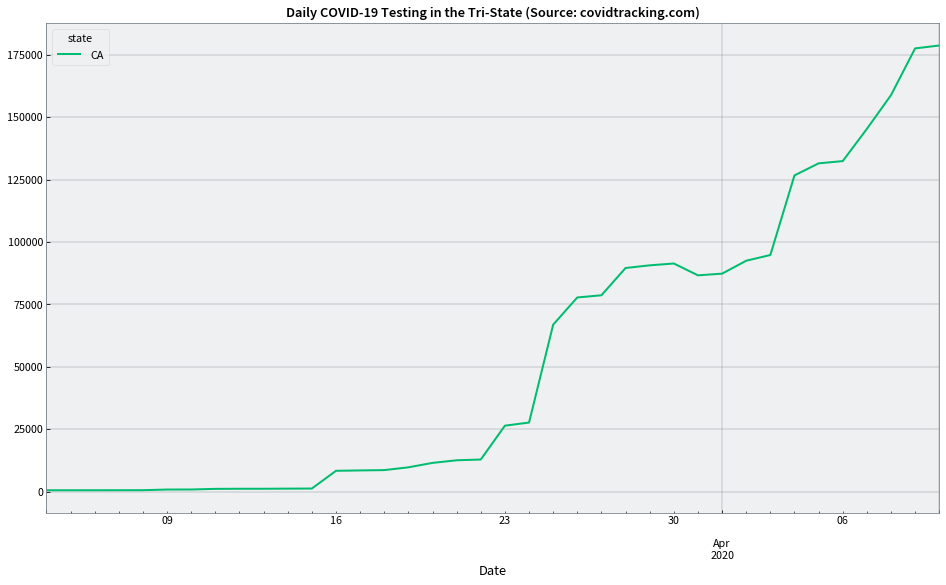

In [315]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['total'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

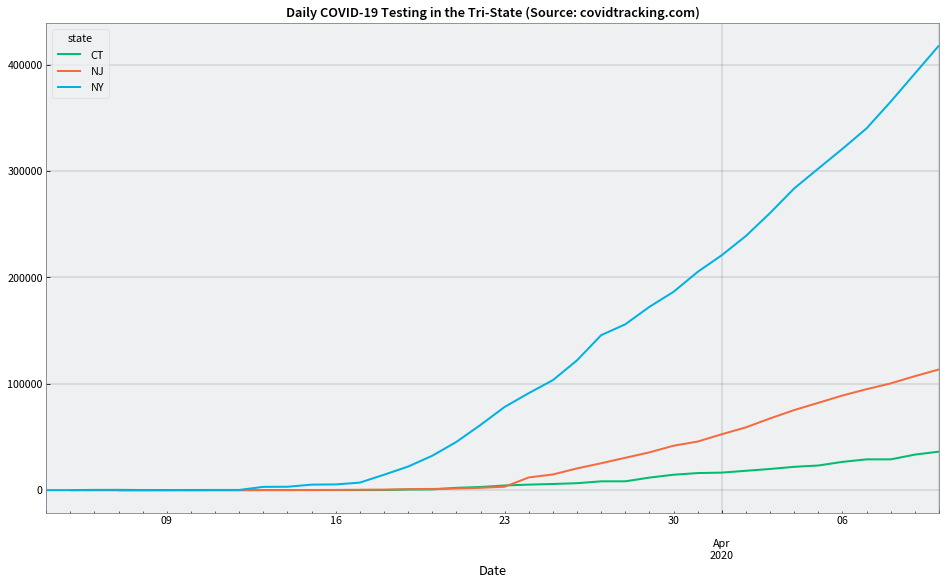

In [316]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'CT', 'NJ'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

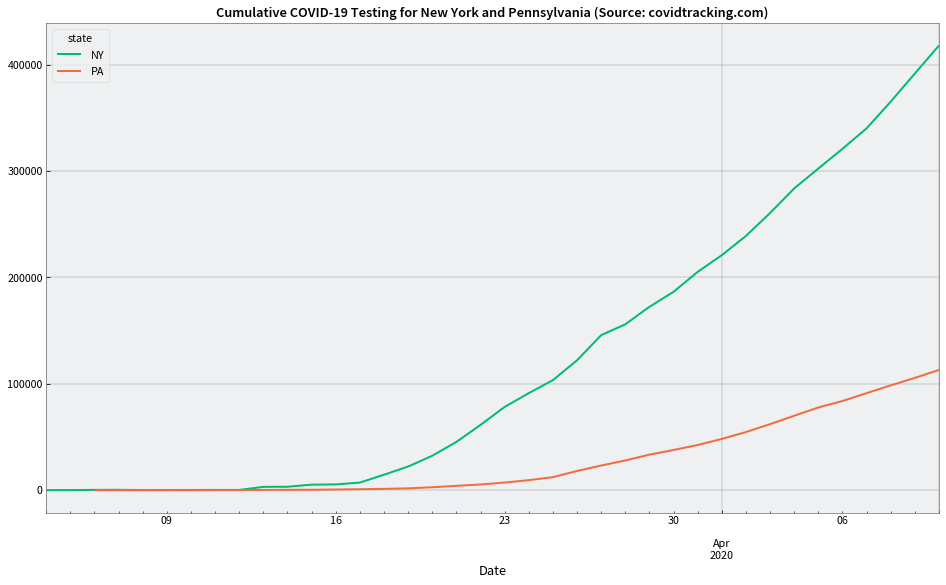

In [317]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'PA'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Pennsylvania (Source: covidtracking.com)")

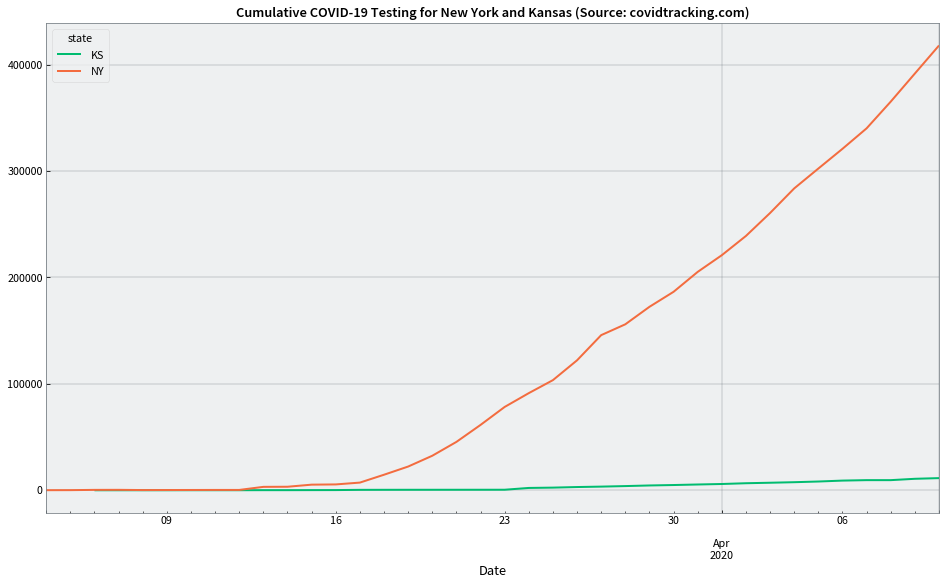

In [318]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Kansas (Source: covidtracking.com)")

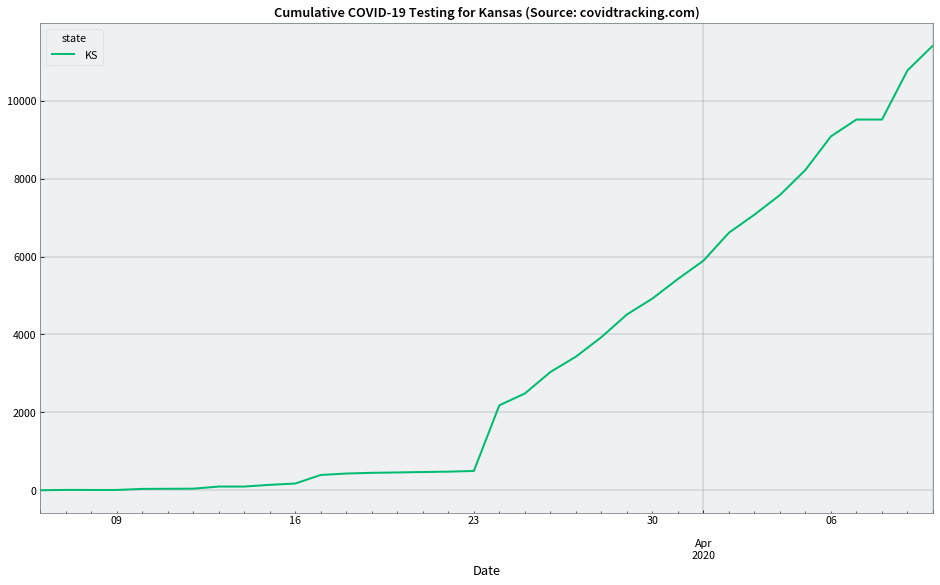

In [319]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

In [320]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

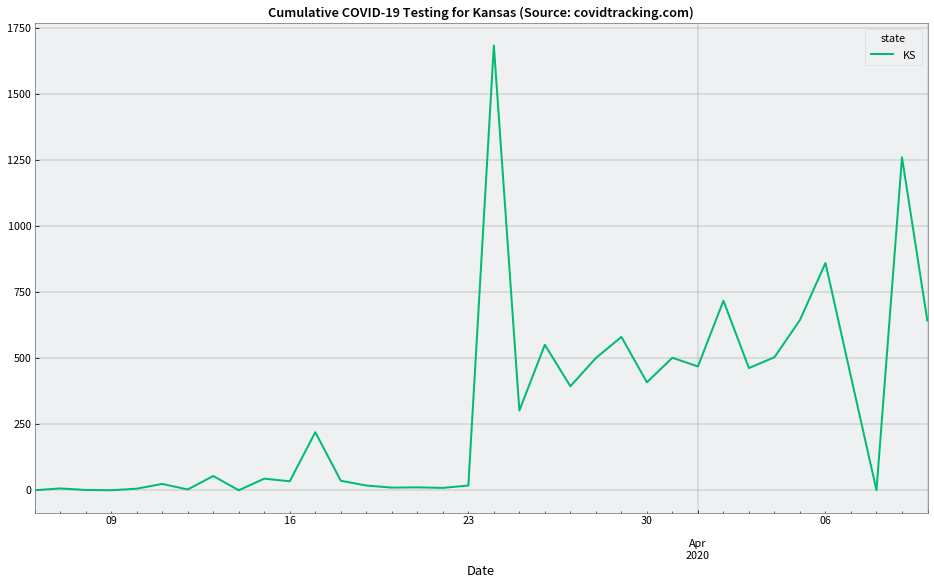

In [321]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

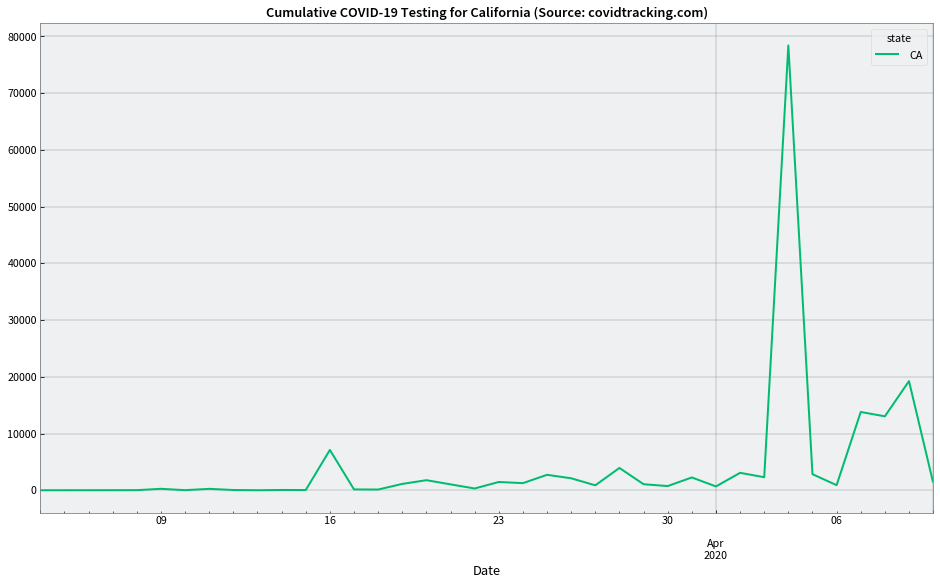

In [322]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for California (Source: covidtracking.com)")

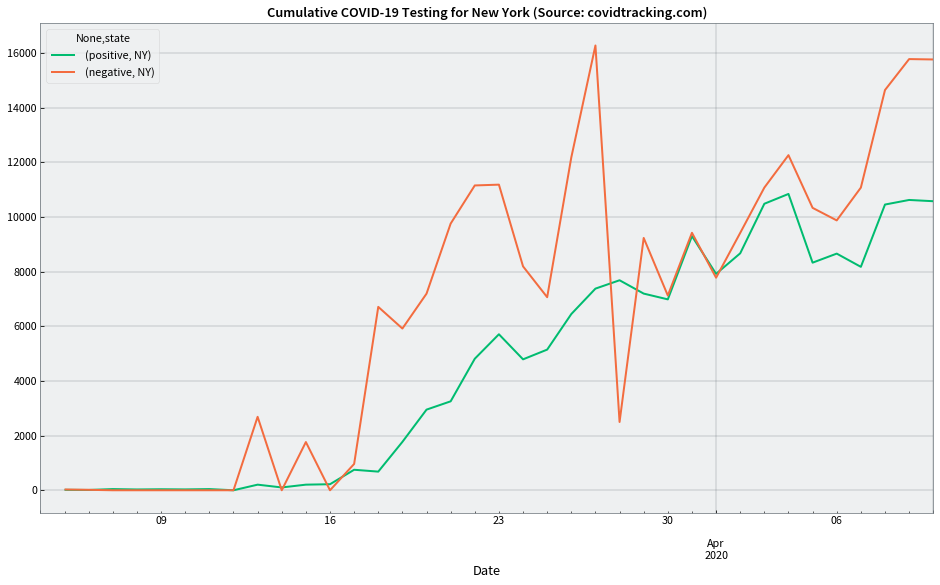

In [323]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])[['positive', 'negative']].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York (Source: covidtracking.com)")

In [324]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

In [325]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100)

Date
2020-03-04         NaN
2020-03-05         NaN
2020-03-06         NaN
2020-03-07         NaN
2020-03-08         NaN
2020-03-09         NaN
2020-03-10         NaN
2020-03-11         NaN
2020-03-12         NaN
2020-03-13         NaN
2020-03-14         NaN
2020-03-15         NaN
2020-03-16         NaN
2020-03-17         NaN
2020-03-18         NaN
2020-03-19         NaN
2020-03-20         NaN
2020-03-21    3.527962
2020-03-22    3.214931
2020-03-23    3.365735
2020-03-24    3.543333
2020-03-25    3.677075
2020-03-26    5.605058
2020-03-27    5.849622
2020-03-28    6.447600
2020-03-29    7.005686
2020-03-30    7.358367
2020-03-31    7.751016
2020-04-01    8.315828
2020-04-02    8.711318
2020-04-03    9.095655
2020-04-04    9.302203
2020-04-05    9.293370
2020-04-06    9.414577
2020-04-07    9.434567
2020-04-08    8.946661
2020-04-09    8.394607
2020-04-10    7.934958
dtype: float64

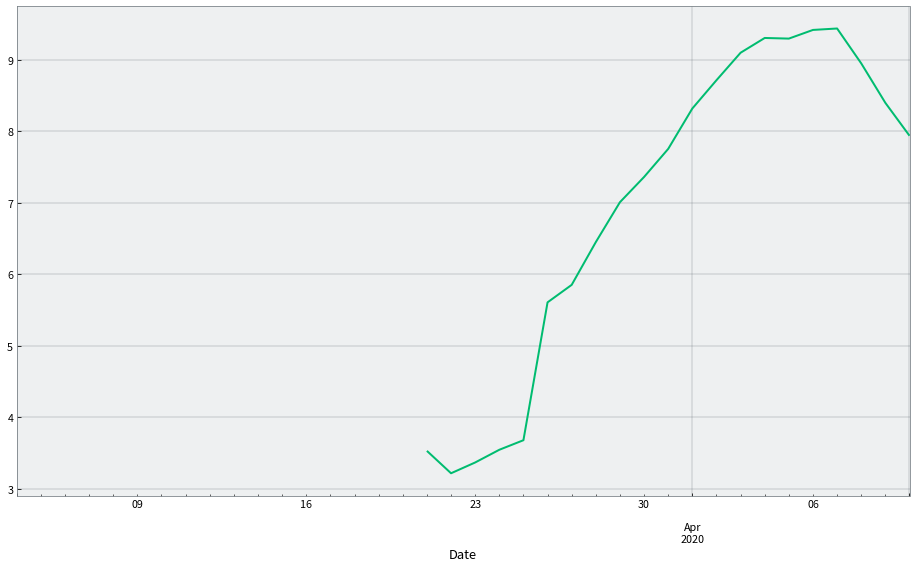

In [326]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100).plot(kind='line')

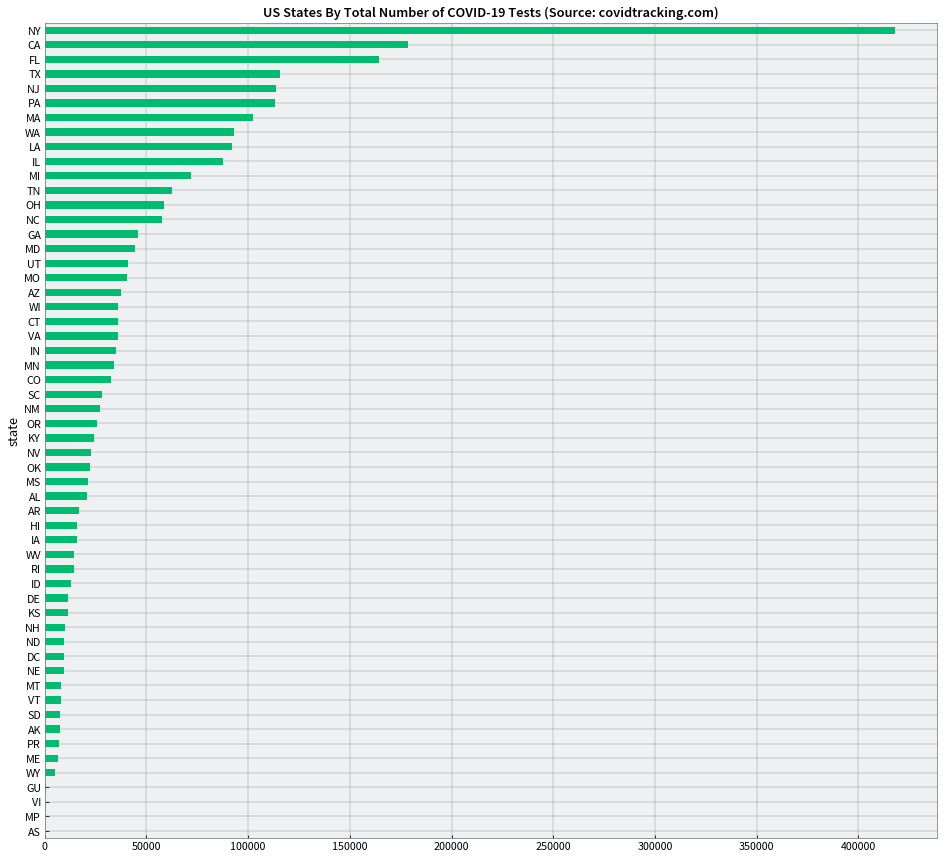

In [327]:
figsize(16,15)
tests_df.groupby('state')['total'].max().sort_values().plot(kind='barh',
                                                            title="US States By Total Number of COVID-19 Tests (Source: covidtracking.com)")

In [328]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values()

state
AS        1.052632
MP        2.000000
VI       16.684211
GU       33.631579
ME      227.421053
WY      241.789474
PR      296.842105
AK      340.210526
SD      362.421053
VT      372.315789
MT      374.736842
DC      436.842105
ND      437.894737
NH      458.157895
NE      471.052632
KS      575.421053
DE      613.105263
ID      625.105263
RI      699.000000
WV      745.157895
IA      770.947368
HI      833.578947
AR      854.947368
AL     1022.315789
MS     1041.052632
NV     1058.473684
OK     1127.789474
NM     1174.684211
OR     1189.578947
KY     1195.631579
SC     1395.894737
CO     1479.105263
MN     1537.578947
WI     1562.000000
VA     1690.631579
CT     1746.736842
IN     1765.578947
UT     1951.210526
AZ     1963.157895
MO     2120.052632
GA     2217.210526
MD     2321.578947
NC     2695.105263
OH     3056.947368
TN     3106.421053
WA     3444.105263
MI     3541.947368
IL     4168.789474
LA     4672.736842
MA     5066.684211
TX     5629.578947
PA     5661.894737
NJ    

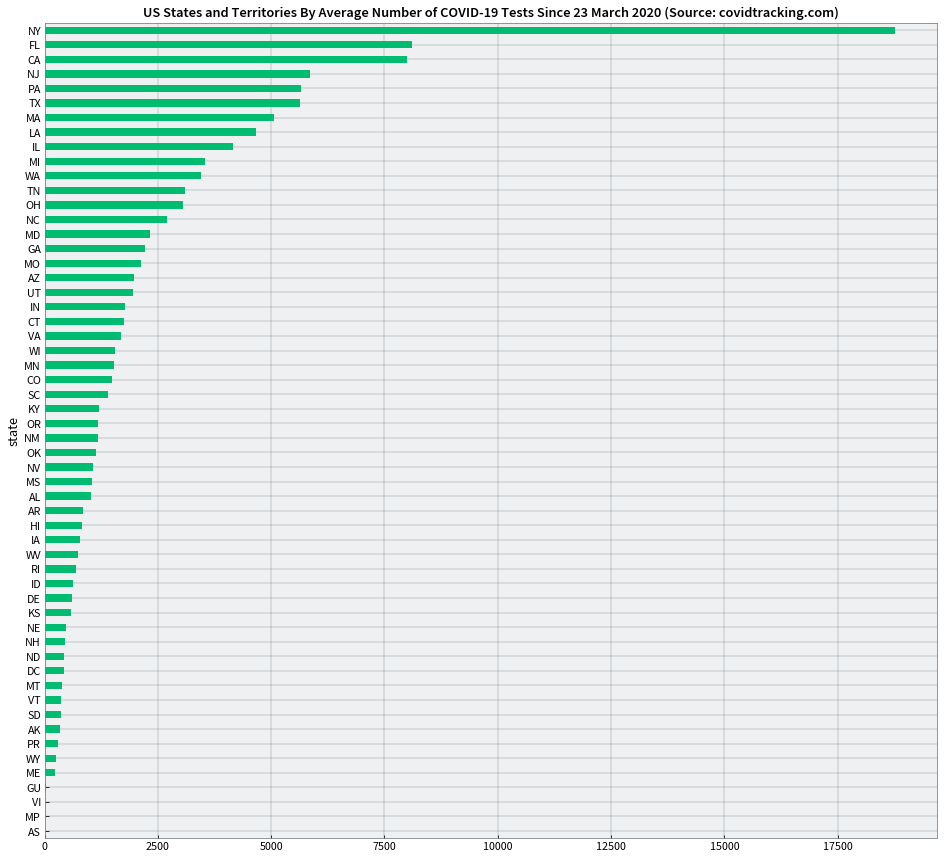

In [329]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values().plot(kind='barh',
                                                                                                                  title="US States and Territories By Average Number of COVID-19 Tests Since 23 March 2020 (Source: covidtracking.com)")

In [330]:
tests_df.groupby('state')['positive'].max().sort_values()

state
AS         0.0
MP        11.0
VI        50.0
GU       130.0
AK       246.0
ND       278.0
WY       320.0
MT       365.0
HI       442.0
SD       536.0
WV       554.0
ME       586.0
NE       635.0
VT       679.0
PR       725.0
NH       819.0
NM      1091.0
KS      1166.0
AR      1171.0
OR      1321.0
DE      1326.0
MN      1336.0
ID      1353.0
IA      1388.0
DC      1660.0
KY      1693.0
OK      1794.0
RI      2015.0
UT      2102.0
MS      2469.0
NV      2584.0
AL      2968.0
SC      3065.0
WI      3068.0
AZ      3112.0
MO      3799.0
NC      3908.0
VA      4509.0
TN      4862.0
OH      5878.0
CO      6510.0
IN      6907.0
MD      6968.0
WA      9608.0
CT     10538.0
GA     11483.0
TX     11671.0
FL     17531.0
IL     17887.0
LA     19253.0
CA     19472.0
PA     19979.0
MA     20974.0
MI     22783.0
NJ     54588.0
NY    170512.0
Name: positive, dtype: float64

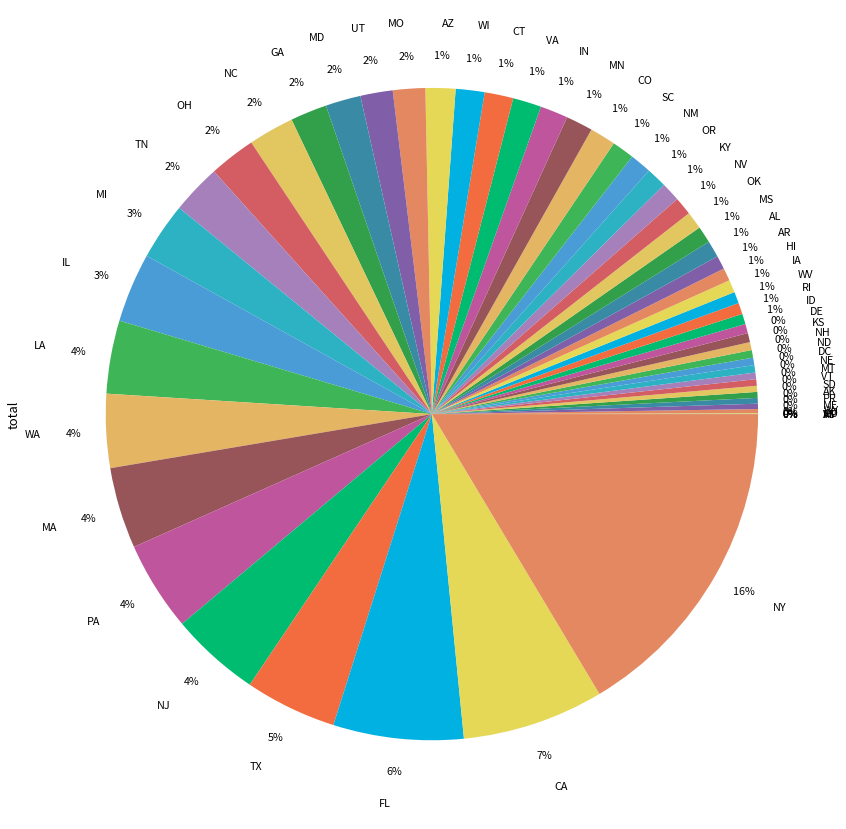

In [331]:
tests_df.groupby('state')['total'].max().sort_values().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,)

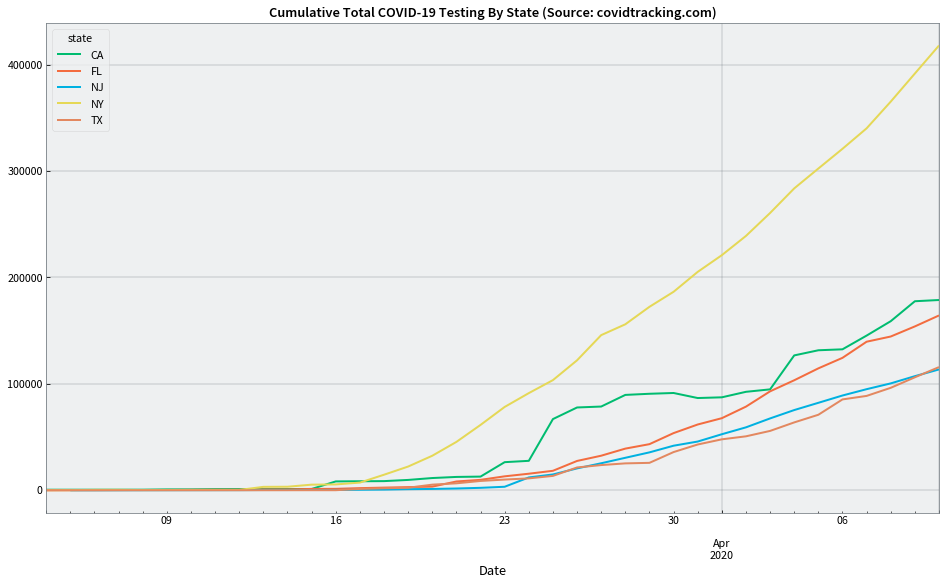

In [332]:
figsize(16, 9)
tests_df[tests_df['state'].isin(tests_df.groupby('state')['total'].max().sort_values()[-5:].index)].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                                                                     title="Cumulative Total COVID-19 Testing By State (Source: covidtracking.com)")

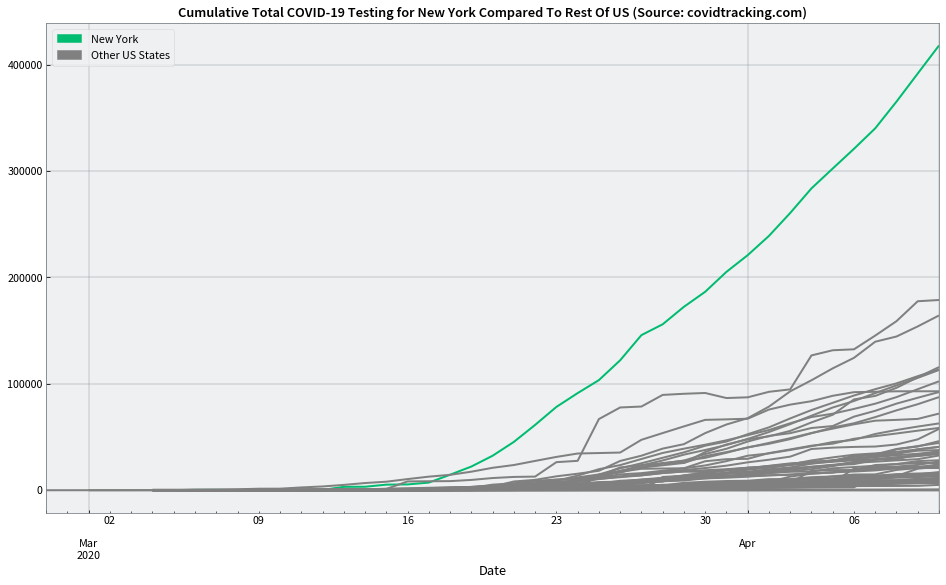

In [333]:


figsize(16, 9)
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                         title="Cumulative Total COVID-19 Testing for New York Compared To Rest Of US (Source: covidtracking.com)")

tests_df[-(tests_df['state'] == 'NY')].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                       color="gray",
                                                                                                       legend=False,
                                                                                                       ax=ax)

patch = mpatches.Patch(color="gray", label="Other US States")
ax.legend(handles=[mpatches.Patch(color="#00bc70", label="New York"),
                   mpatches.Patch(color="gray", label="Other US States")])

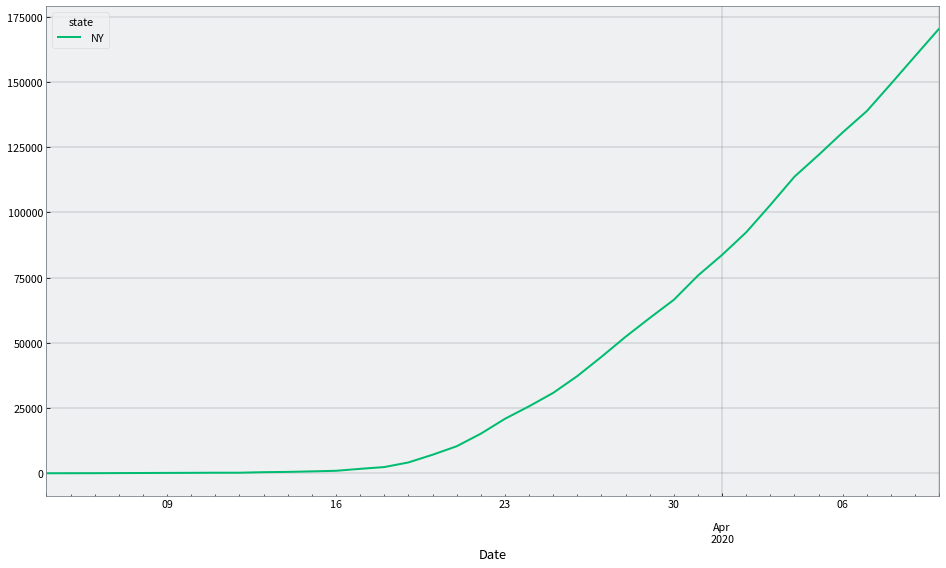

In [334]:
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['positive'].max().unstack('state').plot(kind='line', color="#00bc70", label="Positive COVID-19 Tests")

In [335]:
tests_df['New York?'] = tests_df['state'].str.contains('NY')

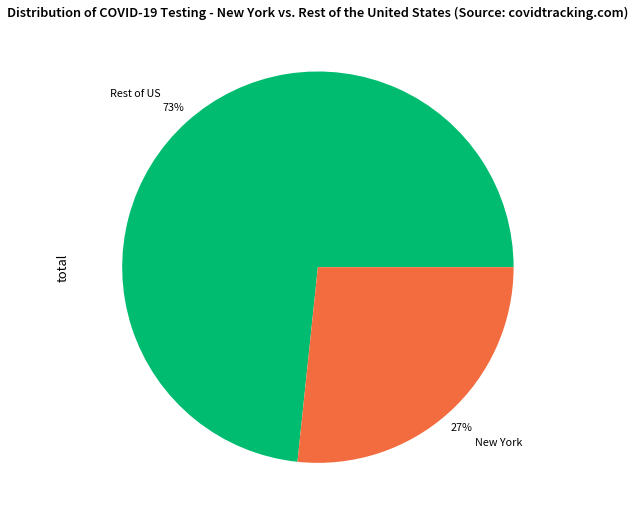

In [336]:
ax = tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,
                                                       title="Distribution of COVID-19 Testing - New York vs. Rest of the United States (Source: covidtracking.com)",
                                                       labels=['Rest of US', 'New York'])

In [337]:
tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum()

New York?
False    168866
True      61401
Name: total, dtype: int64

In [338]:
tests_df.groupby(['Date', 'New York?'])['total'].sum().unstack('New York?').diff()

New York?,False,True
Date,,
2020-02-28,NaN,NaN
2020-02-29,9.0,NaN
2020-03-01,13.0,NaN
2020-03-02,4.0,NaN
2020-03-03,31.0,NaN
2020-03-04,875.0,NaN
2020-03-05,308.0,44.0
2020-03-06,732.0,239.0
2020-03-07,477.0,43.0


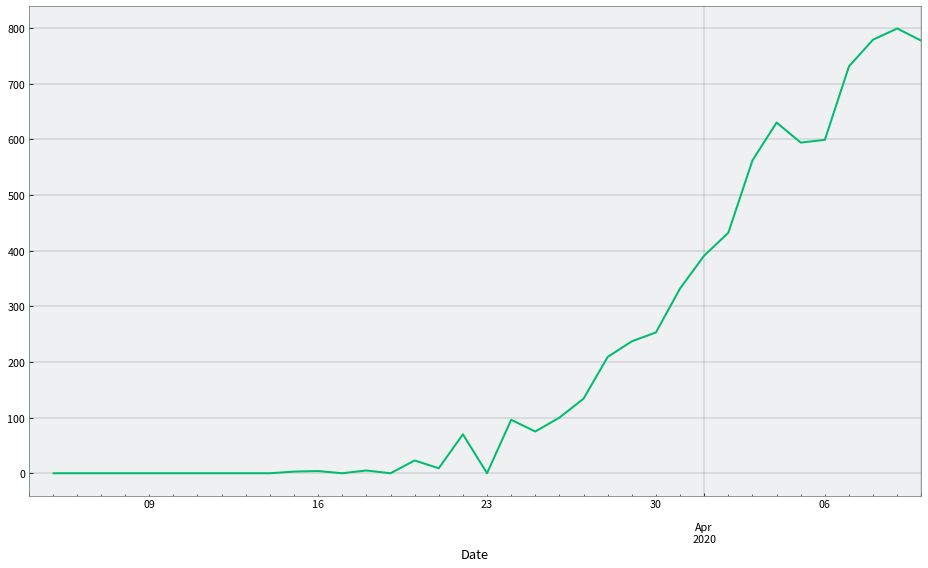

In [339]:
tests_df[tests_df['state'] == 'NY'].groupby('Date')['death'].sum().diff().plot(kind='line')

In [340]:
tests_df['Date'].max()

Timestamp('2020-04-10 00:00:00')

# Kansas

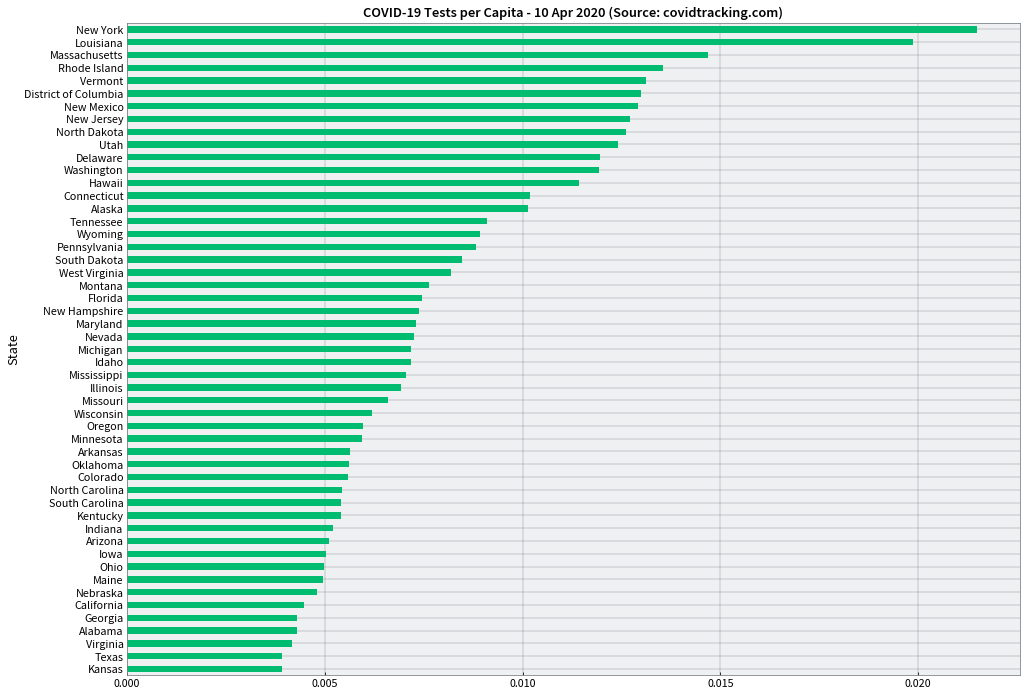

In [341]:
figsize(16, 12)
tests_df.groupby('State')['Tests per Capita'].max().sort_values()[:-4].plot(kind='barh',
                                                                            title="COVID-19 Tests per Capita - {0} (Source: covidtracking.com)".format(tests_df['Date'].max().strftime("%d %b %Y")))

# Pennsylvania

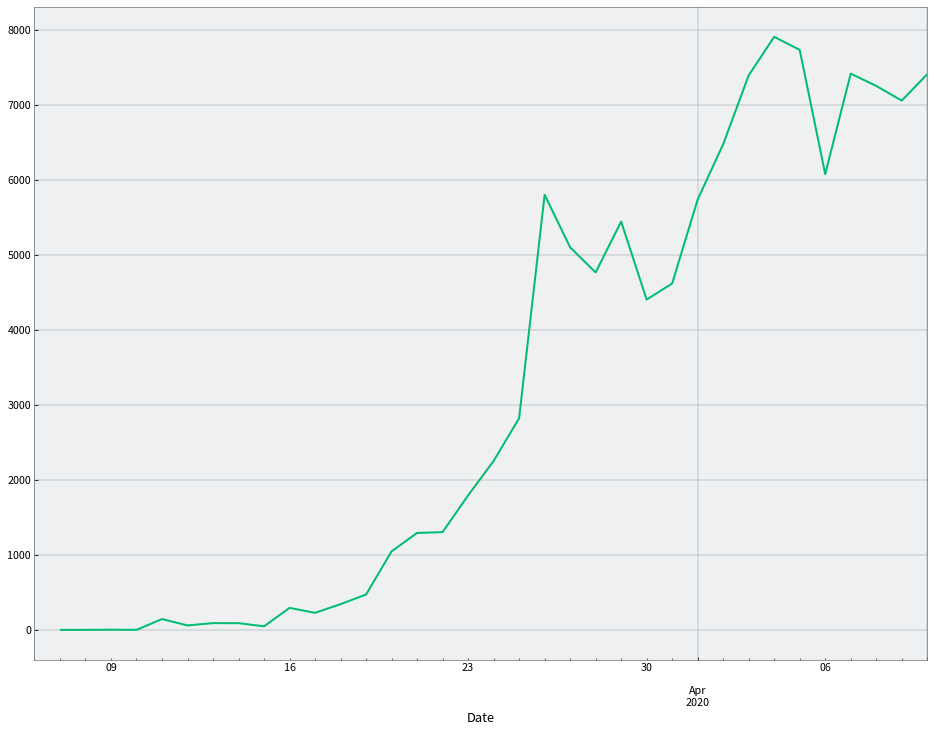

In [291]:
tests_df[tests_df['state'] == 'PA'].groupby('Date')['total'].max().diff().plot(kind='line')